In [ ]:
#|default_exp asink

# The async version

## Setup

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json
from collections import abc
try: from IPython import display
except: display=None

from anthropic import AsyncAnthropic
from anthropic.types import ToolUseBlock
from toolslm.funccall import get_schema, mk_ns, call_func, call_func_async
from fastcore.meta import delegates
from fastcore.utils import *
from claudette.core import *
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs

In [ ]:
#| hide
from nbdev import show_doc

## Async SDK

In [ ]:
model = models[1]
cli = AsyncAnthropic()

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = await cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you just like to chat?

<details>

- id: `msg_01H7LKEnvrgPqzzVj4WKqNFZ`
- content: `[{'citations': None, 'text': "Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you just like to chat?", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 36}`

</details>

In [ ]:
msgs = mk_msgs([prompt, r, "I forgot my name. Can you remind me please?"]) 
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text="Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you just like to chat?", type='text')]},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
await cli.messages.create(messages=msgs, model=model, max_tokens=200)

You just introduced yourself as Jeremy. That's your name based on what you told me in your previous message.

<details>

- id: `msg_01DDbdY9JsybAT33YowQD9kH`
- content: `[{'citations': None, 'text': "You just introduced yourself as Jeremy. That's your name based on what you told me in your previous message.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 60, 'output_tokens': 25}`

</details>

In [ ]:
#| exports
class AsyncClient(Client):
    def __init__(self, model, cli=None, log=False, cache=False):
        "Async Anthropic messages client."
        super().__init__(model,cli,log,cache)
        if not cli: self.c = AsyncAnthropic(default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'})

In [ ]:
c = AsyncClient(model)

In [ ]:
c._r(r)
c.use

In: 10; Out: 36; Cache create: 0; Cache read: 0; Total: 46

In [ ]:
#| exports
@patch
async def _stream(self:AsyncClient, msgs:list, prefill='', **kwargs):
    async with self.c.messages.stream(model=self.model, messages=mk_msgs(msgs, cache=self.cache), **kwargs) as s:
        if prefill: yield prefill
        async for o in s.text_stream: yield o
        self._log(await s.get_final_message(), prefill, msgs, kwargs)

In [ ]:
#| exports
@patch
@delegates(Client)
async def __call__(self:AsyncClient,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             tools:Optional[list]=None, # List of tools to make available to Claude
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             **kwargs):
    "Make an async call to Claude."
    if tools: kwargs['tools'] = [get_schema(o) for o in listify(tools)]
    if tool_choice: kwargs['tool_choice'] = mk_tool_choice(tool_choice)
    if maxthinktok: 
        kwargs['thinking']={'type':'enabled', 'budget_tokens':maxthinktok} 
        temp=1; prefill=''
    msgs = self._precall(msgs, prefill, stop, kwargs)
    if any(t == 'image' for t in get_types(msgs)): assert not self.text_only, f"Images are not supported by the current model type: {self.model}"
    if stream: return self._stream(msgs, prefill=prefill, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    res = await self.c.messages.create(
        model=self.model, messages=msgs, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    return self._log(res, prefill, msgs, maxtok, sp, temp, stream=stream, stop=stop, **kwargs)

In [ ]:
c = AsyncClient(model, log=True)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total: 0

In [ ]:
c.model = models[1]
await c('Hi')

Hello! How can I assist you today? Feel free to ask any questions or let me know what you'd like to discuss.

<details>

- id: `msg_019f1ey5xX5icL17v23wEYhU`
- content: `[{'citations': None, 'text': "Hello! How can I assist you today? Feel free to ask any questions or let me know what you'd like to discuss.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8, 'output_tokens': 29}`

</details>

In [ ]:
c.use

In: 8; Out: 29; Cache create: 0; Cache read: 0; Total: 37

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'
await c(q, prefill=pref)

According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal and varies across philosophical traditions - from finding happiness, serving others, pursuing knowledge, or creating your own purpose in an inherently meaningless universe. There's no universal answer, which is perhaps what makes the question so enduring.

<details>

- id: `msg_01UySeHLz39g2ub288t2aze4`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal and varies across philosophical traditions - from finding happiness, serving others, pursuing knowledge, or creating your own purpose in an inherently meaningless universe. There's no universal answer, which is perhaps what makes the question so enduring.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 24, 'output_tokens': 65}`

</details>

In [ ]:
c.use

In: 32; Out: 94; Cache create: 0; Cache read: 0; Total: 126

In [ ]:
async for o in await c(q, prefill=pref, stream=True): print(o, end='')

According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal and varies across philosophical traditions - from finding happiness, serving others, pursuing knowledge, or creating your own purpose in an inherently meaningless universe. There's no universal answer, which is perhaps what makes the question so enduring.

In [ ]:
c.use

In: 56; Out: 159; Cache create: 0; Cache read: 0; Total: 215

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "You are a summing expert."

In [ ]:
tools=[sums]
choice = mk_tool_choice('sums')
choice

{'type': 'tool', 'name': 'sums'}

In [ ]:
msgs = mk_msgs(pr)
r = await c(msgs, sp=sp, tools=tools, tool_choice=choice)
r

ToolUseBlock(id='toolu_01TSMw6g94AR6cdyvE3Rtdtb', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01WgPFTRNN2YrSphkssjTG6j`
- content: `[{'id': 'toolu_01TSMw6g94AR6cdyvE3Rtdtb', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 438, 'output_tokens': 57}`

</details>

In [ ]:
#| export
async def mk_funcres_async(fc, ns):
    "Given tool use block `fc`, get tool result, and create a tool_result response."
    res = await call_func_async(fc.name, fc.input, ns=ns, raise_on_err=False)
    return dict(type="tool_result", tool_use_id=fc.id, content=str(res))

In [ ]:
#| export
async def mk_toolres_async(
    r:abc.Mapping, # Tool use request response from Claude
    ns:Optional[abc.Mapping]=None, # Namespace to search for tools
    obj:Optional=None # Class to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    cts = getattr(r, 'content', [])
    res = [mk_msg(r.model_dump(), role='assistant')]
    if ns is None: ns=globals()
    if obj is not None: ns = mk_ns(obj)
    tcs = [await mk_funcres_async(o, ns) for o in cts if isinstance(o,ToolUseBlock)]
    if tcs: res.append(mk_msg(tcs))
    return res

In [ ]:
tr = await mk_toolres_async(r, ns=globals())
tr

Finding the sum of 604542 and 6458932


[{'role': 'assistant',
  'content': [{'id': 'toolu_01TSMw6g94AR6cdyvE3Rtdtb',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01TSMw6g94AR6cdyvE3Rtdtb',
    'content': '7063474'}]}]

In [ ]:
msgs += tr
r = contents(await c(msgs, sp=sp, tools=sums))
r

'The sum of 604542 and 6458932 is 7,063,474.'

## Structured Output

In [ ]:
#|export
@patch
@delegates(Client.__call__)
async def structured(self:AsyncClient,
               msgs:list, # List of messages in the dialog
               tools:Optional[list]=None, # List of tools to make available to Claude
               obj:Optional=None, # Class to search for tools  
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    tools = listify(tools)
    if ns is None: ns=mk_ns(*tools)
    if obj is not None: ns = mk_ns(obj)
    res = await self(msgs, tools=tools, tool_choice=tools,**kwargs)
    cts = getattr(res, 'content', [])
    tcs = [await call_func_async(o.name, o.input, ns=ns) for o in cts if isinstance(o,ToolUseBlock)]
    return tcs

In [ ]:
await c.structured(pr, sums)

Finding the sum of 604542 and 6458932


[7063474]

In [ ]:
c

ToolUseBlock(id='toolu_015qtmiS5yq7JQgxCmjvY6au', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 1,448 | 0.004344 |
| Output tokens | 298 | 0.004470 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **1,746** | **$0.008814** |

## AsyncChat

In [ ]:
#| exports
@delegates()
class AsyncChat(Chat):
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 **kwargs):
        "Anthropic async chat client."
        super().__init__(model, cli, **kwargs)
        if not cli: self.c = AsyncClient(model)

In [ ]:
sp = "Never mention what tools you use."
chat = AsyncChat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Cache create: 0; Cache read: 0; Total: 0, [])

In [ ]:
#| exports
@patch
async def _stream(self:AsyncChat, res):
    async for o in res: yield o
    self.h += mk_toolres(self.c.result, ns=self.tools, obj=self)

In [ ]:
#| exports
@patch
async def _append_pr(self:AsyncChat, pr=None):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user' if no history
    if pr and prev_role == 'user': await self()
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
async def __call__(self:AsyncChat,
                   pr=None,  # Prompt / message
                   temp=None, # Temperature
                   maxtok=4096, # Maximum tokens
                   maxthinktok=0, # Maximum thinking tokens
                   stream=False, # Stream response?
                   prefill='', # Optional prefill to pass to Claude as start of its response
                   tool_choice:Optional[Union[str,bool,dict]]=None, # Optionally force use of some tool
                   **kw):
    if temp is None: temp=self.temp
    await self._append_pr(pr)
    res = await self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok, maxthinktok=maxthinktok, tools=self.tools, tool_choice=tool_choice, **kw)
    if stream: return self._stream(res)
    self.h += await mk_toolres_async(self.c.result, ns=self.ns)
    return res

In [ ]:
await chat("I'm Jeremy")
await chat("What's my name?")

Your name is Jeremy, as you mentioned in your previous message.

<details>

- id: `msg_011pCCZaehUHEokcUdfw9HBV`
- content: `[{'citations': None, 'text': 'Your name is Jeremy, as you mentioned in your previous message.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 59, 'output_tokens': 16}`

</details>

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'
await chat(q, prefill=pref)

According to Douglas Adams,  42. More seriously, the meaning of life is likely what you create through your relationships, pursuits, and values.

<details>

- id: `msg_01HnHJXGu96Sz71NCEG5P7mM`
- content: `[{'citations': None, 'text': 'According to Douglas Adams,  42. More seriously, the meaning of life is likely what you create through your relationships, pursuits, and values.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 95, 'output_tokens': 28}`

</details>

In [ ]:
chat = AsyncChat(model, sp=sp)
async for o in await chat("I'm Jeremy", stream=True): print(o, end='')

Hello Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to chat?

In [ ]:
pr = f"What is {a}+{b}?"
chat = AsyncChat(model, sp=sp, tools=[sums])
r = await chat(pr)
r

Finding the sum of 604542 and 6458932


I'll calculate the sum of those two numbers for you.

<details>

- id: `msg_01JwSYNZPzyZz8Dx8F4UYm2B`
- content: `[{'citations': None, 'text': "I'll calculate the sum of those two numbers for you.", 'type': 'text'}, {'id': 'toolu_012EnQPvNddWvJoPyeXpozqF', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 437, 'output_tokens': 85}`

</details>

In [ ]:
pr += " Say the answer in a sentence."
chat = AsyncChat(model, sp=sp, tools=[sums])
r = await chat(pr)
r

Finding the sum of 604542 and 6458932


Let me calculate that sum for you.

<details>

- id: `msg_01UCQMWn7W96VEBRUhZrvTJE`
- content: `[{'citations': None, 'text': 'Let me calculate that sum for you.', 'type': 'text'}, {'id': 'toolu_01Mdk5rDKjYRxSCKAdgp911d', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 444, 'output_tokens': 81}`

</details>

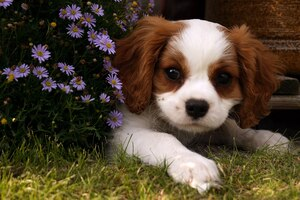

In [ ]:
fn = Path('samples/puppy.jpg')
img = fn.read_bytes()
display.Image(img)

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img, q])
await c([msg])

The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers or asters blooming in the background, while in the foreground there's an adorable Cavalier King Charles Spaniel puppy (or similar breed) with white and brown fur resting on the grass.

<details>

- id: `msg_01Q7ydoG1m2RnRB5gZfcpbyV`
- content: `[{'citations': None, 'text': "The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers or asters blooming in the background, while in the foreground there's an adorable Cavalier King Charles Spaniel puppy (or similar breed) with white and brown fur resting on the grass.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 71}`

</details>

Add `cache=True` to automatically add to Claude's KV cache. Cache creation tokens are a little more expensive, but cache read tokens are *far* cheaper.

In [ ]:
chat = AsyncChat(model, sp=sp, cache=True)
await chat("Lorem ipsum dolor sit amet" * 150)
chat.use

In: 4; Out: 81; Cache create: 1058; Cache read: 0; Total: 1143

In this followup call, nearly all the tokens are cached, so the only the new additional tokens are charged at the full rate.

In [ ]:
await chat("Whoops, sorry about that!")
chat.use

In: 8; Out: 124; Cache create: 1150; Cache read: 1058; Total: 2340

## Extended Thinking

Claude 3.7 Sonnet has enhanced reasoning capabilities for complex tasks. See [docs](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking) for more info.

We can enable extended thinking by passing a `thinking` param with the following structure.

```js
thinking={
    "type": "enabled",
    "budget_tokens": 16000
}
```

When extended thinking is enabled a thinking block is included in the response as shown below.

```js
{
  "content": [
    {
      "type": "thinking",
      "thinking": "To approach this, let's think about...",
      "signature": "Imtakcjsu38219c0.eyJoYXNoIjoiYWJjM0NTY3fQ...."
    },
    {
      "type": "text",
      "text": "Yes, there are infinitely many prime numbers such that..."
    }
  ]
}
```

Let's call the model without extended thinking enabled. 

In [ ]:
tk_model = first(has_extended_thinking_models)
chat = AsyncChat(tk_model)
await chat("Write a sentence about Python!")

Python is a versatile programming language known for its readable syntax and wide application in fields ranging from web development to data science and artificial intelligence.

<details>

- id: `msg_01E3t5hoTy6zkhpPMQt1vSwU`
- content: `[{'citations': None, 'text': 'Python is a versatile programming language known for its readable syntax and wide application in fields ranging from web development to data science and artificial intelligence.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 13, 'output_tokens': 31}`

</details>

Now, let's call the model with extended thinking enabled.

In [ ]:
r = await chat("Write a sentence about Python!", maxthinktok=1024)
r.content

[ThinkingBlock(signature='ErUBCkYIAxgCIkDwYbWFKH4ZQ5LSZkTNjfHbEYCnHto5D9aeutnOwtJJU2DwMCKNMzK35Yh3KB3DrhHZ0caUCK/6dZAApKCnMz0kEgxc7SfWMEwuZ2+LKzYaDFTsHiFn9/uDsxq7PyIwuhmdrnQe9GjrcZ75auo5nwxegWiHaXyRxXY90JORQBmflZr5FF4YNJZr49tSij8GKh2WfwmADPz3GoCMz4V87aNSMd9EtD0Q5RoONkfkPBgC', thinking="I'm being asked again to write a sentence about Python. Since I've provided two different sentences in my previous responses, I should make sure to write yet another unique sentence about Python to avoid repetition. I'll focus on a different aspect of Python that I haven't mentioned yet, such as its community, ecosystem, history, or specific technical features.", type='thinking'),
 TextBlock(citations=None, text='The robust Python ecosystem boasts thousands of third-party packages that enable developers to quickly build applications without reinventing the wheel, making it one of the most productive programming languages available today.', type='text')]

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()